**Task 4**

**The code provided covers the task 4. It includes:**

1. Loading and preprocessing the dataset.
2. Creating binary classification models for root, seed, shoot, and occluded_root.
3. Training these models and visualizing their learning curves.
4. Calculating IoU on the test set for each binary classification model.
5. Providing example input images and resulting segmentation masks for visualization.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from patchify import patchify, unpatchify

import tensorflow.keras.backend as K
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Specify the desired working directory
my_directory = r'C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4'

# Change the working directory
os.chdir(my_directory)

# Print the updated working directory
print("My working directory:", os.getcwd())

My working directory: C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4


In [80]:
parent_dir = "Dataset"
masks_dir = "Masks"
patch_dir = "Patched"

test_dir = "test"
train_dir = "train"

train_path = os.path.join(parent_dir, train_dir)
test_path = os.path.join(parent_dir, test_dir)

patch_train_path = os.path.join(patch_dir, train_dir)
patch_test_path = os.path.join(patch_dir, test_dir)

In [81]:
# Using images that is already read by cv2
def dim_crop(im):
    # Remove unnecessary pixels
    im = im[0:3000, 0:4000]
    
    # Filtering
    im_blurred = cv2.medianBlur(im, 5)
    th, output_im = cv2.threshold(im_blurred, 50, 250, cv2.THRESH_BINARY_INV)
    kernel = np.ones((11, 11), np.uint8)
    output_im = cv2.erode(output_im, kernel, iterations=1)
    output_im = cv2.dilate(output_im, kernel, iterations=1)

    # Get the dimensions of dish
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)
    x, y, w, h, _ = stats[0]

    # Check which side is longer to store in side_length, so no data will be lost
    side_length = max(w, h) - 20

    # This part ensures that the cropped image will be centered
    lx = max(min(x + w // 2 - side_length // 2, im.shape[1] - side_length), 0)
    ly = max(min(y + h // 2 - side_length // 2, im.shape[0] - side_length), 0)
    rx = lx + side_length
    ry = ly + side_length
    
    return ly, ry, lx, rx

In [82]:
def all_paths(fpath):
    image_file = os.path.basename(fpath)
        
    root_mask_path = image_file[:-4] + "_root_mask.tif"
    shoot_mask_path = image_file[:-4] + "_shoot_mask.tif"
    seed_mask_path = image_file[:-4] + "_seed_mask.tif"
    occ_root_mask_path = image_file[:-4] + "_occluded_root_mask.tif" 
    all_paths = [shoot_mask_path,root_mask_path, occ_root_mask_path, seed_mask_path]
    return all_paths

In [83]:
def check_all_paths(all_paths, masks_dir):
    for mask_path in all_paths:
        mask_full_path = os.path.join(masks_dir, mask_path)  # Construct the full file path
        if not os.path.exists(mask_full_path):
            return False  # Return False - a non-existing path is found
    return True  # Return True - after checking all paths and finding them all existing

In [84]:
def img_read(fpath):
    orig_img = cv2.imread(fpath)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    return orig_img

In [85]:
def img_resize(fpath, img_size):
    img = img_read(fpath)
    ly, ry, lx, rx = dim_crop(img)
    img = img[ly:ry, lx:rx]
    img = img/255
    img = cv2.resize(img, (img_size, img_size))
    return img

In [86]:
def to_get_the_masks(all_masks_paths, img_size, fpath, masks_dir):
    # Create a 5-channel map initialized with zeros
    masks = np.zeros((img_size, img_size, 5), dtype=np.float32)
    
    # The first channel is for background, initially set to 1 (assuming background is class 0)
    masks[:, :, 0] = 1

    for i, mask_path in enumerate(all_masks_paths):
        mask_full_path = os.path.join(masks_dir, mask_path)
        mask = cv2.imread(mask_full_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        ly, ry, lx, rx = dim_crop(img_read(fpath))  # Assuming these functions are defined elsewhere
        mask = mask[ly:ry, lx:rx]
        mask = cv2.resize(mask, (img_size, img_size))

        # Update the corresponding mask channel and the background channel
        masks[:, :, i+1][mask != 0] = 1  # Set 1s for the current class mask
        masks[:, :, 0][mask != 0] = 0    # Set corresponding background to 0

    return masks

In [87]:
def to_save_dataset_patched(fpath, settype, img_patches, mask_patches, patch_size, img_size):
    img_patches = img_patches.reshape(-1, patch_size, patch_size, 1)
    mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 5)
    factor = img_size // patch_size

    img_patch_path = fpath.replace('Dataset', f'Patched/images/{settype}')
    for i, patch in enumerate(img_patches):
        col = (i + factor) // factor
        row = (i + factor) % factor + 1
        image_patch_path_numbered = f'{img_patch_path[:-4]}_{col}_{row}.png'
        cv2.imwrite(image_patch_path_numbered, patch)

    mask_patch_path = img_patch_path.replace('images', 'masks')
    print(mask_patch_path)
    mask_patch_path = f'{mask_patch_path[:-4]}_mask'
    for i, patch in enumerate(mask_patches):
        col = (i + factor) // factor
        row = (i + factor) % factor + 1
        mask_patch_path_numbered = f'{mask_patch_path}_{col}_{row}.png'
        cv2.imwrite(mask_patch_path_numbered, patch)

In [88]:
def create_dataset(path, settype, masks_dir, img_size, patch_size):
    X = []
    y = []
    for fpath in glob.glob(path + '/*.png'):
        all_masks_paths = all_paths(fpath)
        
        if not check_all_paths(all_masks_paths, masks_dir):
            continue

        img = img_resize(fpath, img_size)
        mask = to_get_the_masks(all_masks_paths, img_size, fpath, masks_dir)
        
        img_patches = patchify(img, (patch_size, patch_size), step=patch_size)
        mask_patches = patchify(mask, (patch_size, patch_size, 5), step=patch_size)
        
        #save_patched_dataset(fpath, settype, img_patches, mask_patches, patch_size, img_size)

        X.append(img_patches)
        y.append(mask_patches)

    X = np.array(X)
    y = np.array(y)
    y = np.squeeze(y, axis=3)

    print("Dataset: X =", X.shape, ", y =", y.shape)

    return X, y

In [89]:
X_train, y_train = create_dataset(train_path,'train', masks_dir, img_size=2048, patch_size=256)

Dataset created: X = (58, 8, 8, 256, 256) , y = (58, 8, 8, 256, 256, 5)


In [90]:
X_test, y_test = create_dataset(test_path,'test', masks_dir, img_size=2048, patch_size=256)

Dataset created: X = (27, 8, 8, 256, 256) , y = (27, 8, 8, 256, 256, 5)


In [91]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("Reshaped: X_train =", X_train.shape, ", y_train =", y_train.shape, ", X_test =", X_test.shape, ", y_test =", y_test.shape)

Reshaped: X_train = (58, 8, 8, 256, 256, 1) , y_train = (58, 8, 8, 256, 256, 5) , X_test = (27, 8, 8, 256, 256, 1) , y_test = (27, 8, 8, 256, 256, 5)


In [92]:
X_train = X_train.reshape(-1, 256,256, 1)
X_test = X_test.reshape(-1, 256,256, 1)
y_train = y_train.reshape(-1, 256,256, 5)
y_test = y_test.reshape(-1, 256,256, 5)
print("Reshaped: X_train =", X_train.shape, ", y_train =", y_train.shape, ", X_test =", X_test.shape, ", y_test =", y_test.shape)

Reshaped: X_train = (3712, 256, 256, 1) , y_train = (3712, 256, 256, 5) , X_test = (1728, 256, 256, 1) , y_test = (1728, 256, 256, 5)


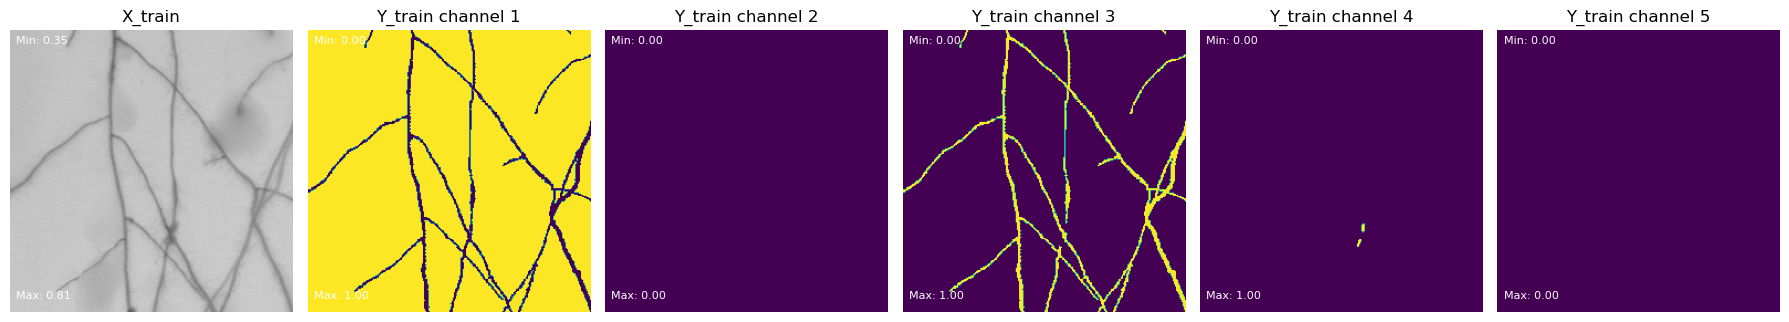

In [93]:
# Select a random sample from X_train and Y_train for visualization
sample_index = np.random.randint(0, len(X_train))

# Separate X_train and Y_train into individual channels
x_channel = X_train[sample_index, :, :, 0]  # Assuming X_train is (3840, 256, 256, 1)
y_channels = y_train[sample_index, :, :, :]   # Assuming Y_train is (3840, 256, 256, 5)

# Get min and max values of X_train
x_min = np.min(x_channel)
x_max = np.max(x_channel)

# Create subplots to display X_train and 5 channels of Y_train
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

# Plot X_train with min and max annotations
axes[0].imshow(x_channel, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('X_train')
axes[0].axis('off')
axes[0].text(5, 5, f'Min: {x_min:.2f}', color='white', fontsize=8, verticalalignment='top')
axes[0].text(5, 245, f'Max: {x_max:.2f}', color='white', fontsize=8, verticalalignment='bottom')

# Plot each channel of Y_train
for i in range(5):
    channel = y_channels[:, :, i]
    axes[i + 1].imshow(channel, cmap='viridis', vmin=0, vmax=1)  # You can change the colormap as needed
    axes[i + 1].set_title(f'Y_train channel {i + 1}')
    axes[i + 1].axis('off')
    min_val = np.min(channel)
    max_val = np.max(channel)
    axes[i + 1].text(5, 5, f'Min: {min_val:.2f}', color='white', fontsize=8, verticalalignment='top')
    axes[i + 1].text(5, 245, f'Max: {max_val:.2f}', color='white', fontsize=8, verticalalignment='bottom')


plt.tight_layout()
plt.show()

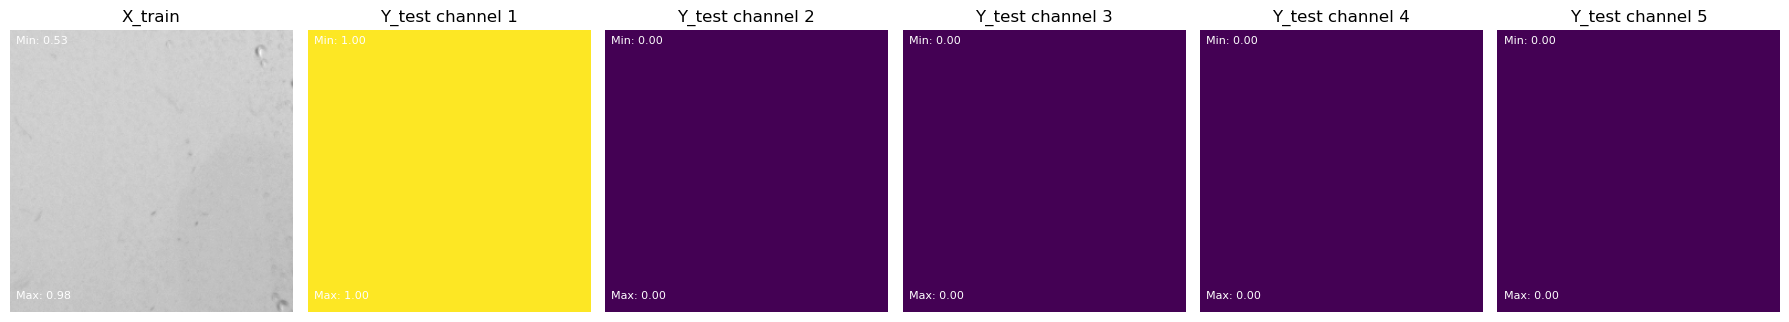

In [94]:
# Select a random sample from X_train and Y_train for visualization
sample_index = np.random.randint(0, len(X_test))

# Separate X_train and Y_train into individual channels
x_channel = X_test[sample_index, :, :, 0]  # Assuming X_train is (3840, 256, 256, 1)
y_channels = y_test[sample_index, :, :, :]   # Assuming Y_train is (3840, 256, 256, 5)

# Get min and max values of X_train
x_min = np.min(x_channel)
x_max = np.max(x_channel)

# Create subplots to display X_train and 5 channels of Y_train
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

# Plot X_train with min and max annotations
axes[0].imshow(x_channel, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('X_train')
axes[0].axis('off')
axes[0].text(5, 5, f'Min: {x_min:.2f}', color='white', fontsize=8, verticalalignment='top')
axes[0].text(5, 245, f'Max: {x_max:.2f}', color='white', fontsize=8, verticalalignment='bottom')

# Plot each channel of Y_train
for i in range(5):
    channel = y_channels[:, :, i]
    axes[i + 1].imshow(channel, cmap='viridis', vmin=0, vmax=1)  # You can change the colormap as needed
    axes[i + 1].set_title(f'Y_test channel {i + 1}')
    axes[i + 1].axis('off')
    min_val = np.min(channel)
    max_val = np.max(channel)
    axes[i + 1].text(5, 5, f'Min: {min_val:.2f}', color='white', fontsize=8, verticalalignment='top')
    axes[i + 1].text(5, 245, f'Max: {max_val:.2f}', color='white', fontsize=8, verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [95]:
y_train_root = y_train[:, :, :, 2:3]  # This slices out the third channel
y_test_root = y_test[:, :, :, 2:3]  # This slices out the third channel

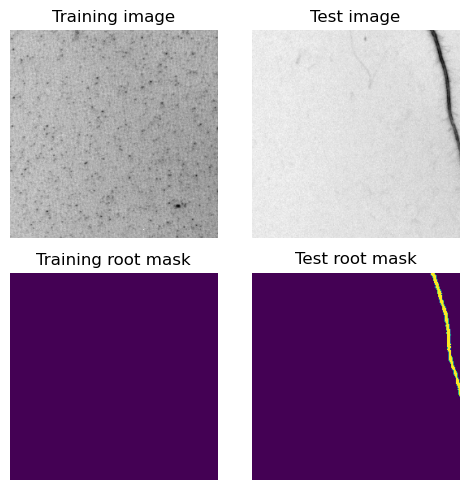

In [96]:
# Select a random sample from y_train_root and y_test_root for visualization
sample_index = np.random.randint(0, len(y_test_root))

# Get the root masks for the selected samples
train_root_mask = y_train_root[sample_index, :, :, 0]  # Squeeze the single channel
test_root_mask = y_test_root[sample_index, :, :, 0]  # Squeeze the single channel

# Get the corresponding input images for the selected samples
train_image = X_train[sample_index, :, :, 0]  # Assuming X_train has the same indexing as y_train_root
test_image = X_test[sample_index, :, :, 0]  # Assuming X_test has the same indexing as y_test_root

# Create subplots to display the training and test images and root masks
fig, axes = plt.subplots(2, 2, figsize=(5, 5))  # 2 rows, 2 columns

# Plot the training image
axes[0, 0].imshow(train_image, cmap='gray')
axes[0, 0].set_title('Training image')
axes[0, 0].axis('off')

# Plot the training root mask
axes[1, 0].imshow(train_root_mask, cmap='viridis')
axes[1, 0].set_title('Training root mask')
axes[1, 0].axis('off')

# Plot the test image
axes[0, 1].imshow(test_image, cmap='gray')
axes[0, 1].set_title('Test image')
axes[0, 1].axis('off')

# Plot the test root mask
axes[1, 1].imshow(test_root_mask, cmap='viridis')
axes[1, 1].set_title('Test root mask')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

**Binary model on roots**

In [97]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [98]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [99]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
def simple_bin_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1, iou])
    
    return model

In [100]:
bin_model = simple_bin_unet_model(256, 256, 1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=2, restore_best_weights=True) # Mode is max for own metrics
history = bin_model.fit(X_train, y_train_root, validation_data=(X_test, y_test_root), epochs=10, batch_size=32, callbacks=early_stop)

Epoch 1/10
116/116 [==============================] - 806s 7s/step - loss: 0.0624 - accuracy: 0.9891 - f1: 1.8288e-04 - iou: 0.0071 - val_loss: 0.0373 - val_accuracy: 0.9929 - val_f1: 0.0000e+00 - val_iou: 0.0083
Epoch 2/10
116/116 [==============================] - 750s 6s/step - loss: 0.0394 - accuracy: 0.9904 - f1: 0.2388 - iou: 0.0659 - val_loss: 0.0230 - val_accuracy: 0.9928 - val_f1: 0.3072 - val_iou: 0.1125
Epoch 3/10
116/116 [==============================] - 719s 6s/step - loss: 0.0227 - accuracy: 0.9928 - f1: 0.6034 - iou: 0.1486 - val_loss: 0.0146 - val_accuracy: 0.9952 - val_f1: 0.4102 - val_iou: 0.1276
Epoch 4/10
116/116 [==============================] - 756s 7s/step - loss: 0.0169 - accuracy: 0.9940 - f1: 0.6785 - iou: 0.1776 - val_loss: 0.0116 - val_accuracy: 0.9960 - val_f1: 0.4841 - val_iou: 0.1655
Epoch 5/10
116/116 [==============================] - 696s 6s/step - loss: 0.0142 - accuracy: 0.9946 - f1: 0.7270 - iou: 0.1929 - val_loss: 0.0105 - val_accuracy: 0.9962 - 

In [101]:
bin_y_pred = bin_model.predict(X_test)  # Assuming X_train is your input data

54/54 [==============================] - 69s 1s/step


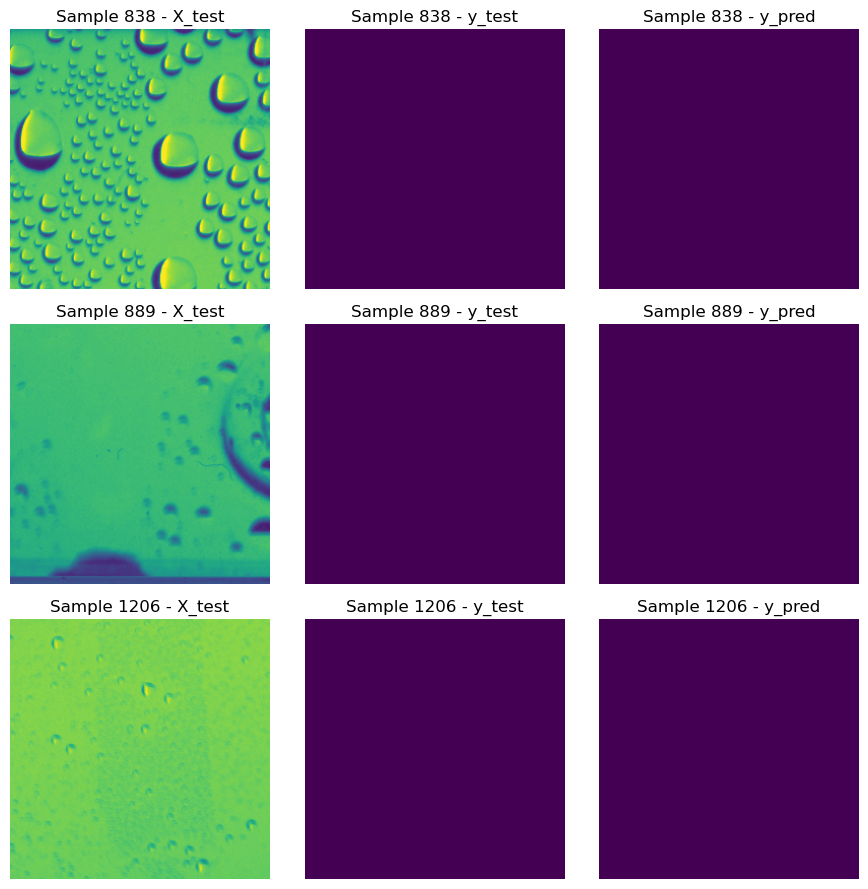

In [102]:
random_indices = np.random.choice(X_test.shape[0], 3, replace=False)

#Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

# Loop through each row and plot X_test, y_test, and y_pred for the corresponding random index
for i, idx in enumerate(random_indices):
    ax_X = axes[i, 0]
    ax_y_test_root = axes[i, 1]
    ax_bin_y_pred = axes[i, 2]

    ax_X.imshow(X_test[idx], cmap='viridis', vmin=0, vmax=1)
    ax_X.set_title(f'Sample {idx} - X_test')
    ax_X.axis('off')

    ax_y_test_root.imshow(y_test_root[idx], cmap='viridis', vmin=0, vmax=1)
    ax_y_test_root.set_title(f'Sample {idx} - y_test')
    ax_y_test_root.axis('off')

    ax_bin_y_pred.imshow(bin_y_pred[idx]>0.5, cmap='viridis', vmin=0, vmax=1)
    ax_bin_y_pred.set_title(f'Sample {idx} - y_pred')
    ax_bin_y_pred.axis('off')

plt.tight_layout()
plt.show()

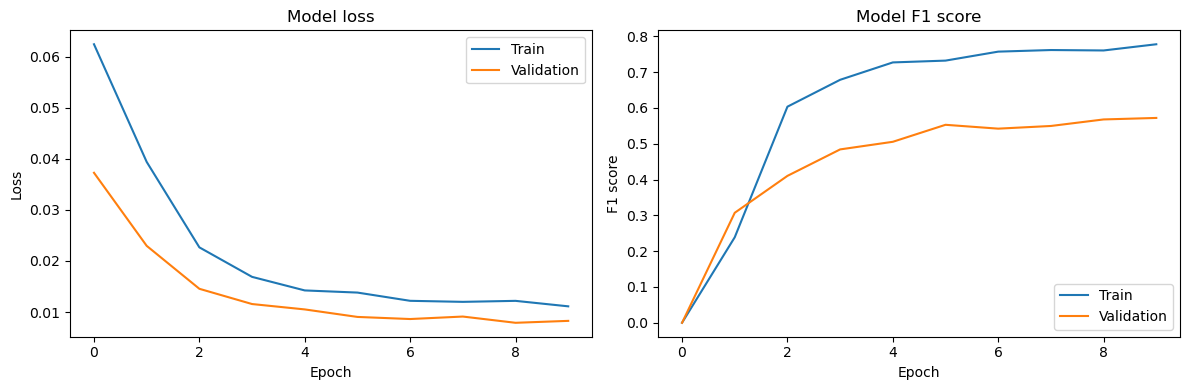

In [103]:
# Plotting learning curves
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [104]:
# Calculate IoU on the test set
test_iou = iou(y_test_root, bin_y_pred).numpy().mean()
print(f'IoU on the test set: {test_iou:.4f}')

IoU on the test set: 0.1909


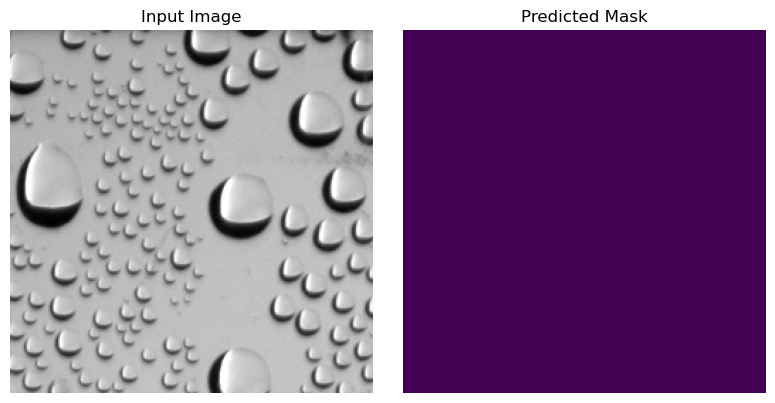

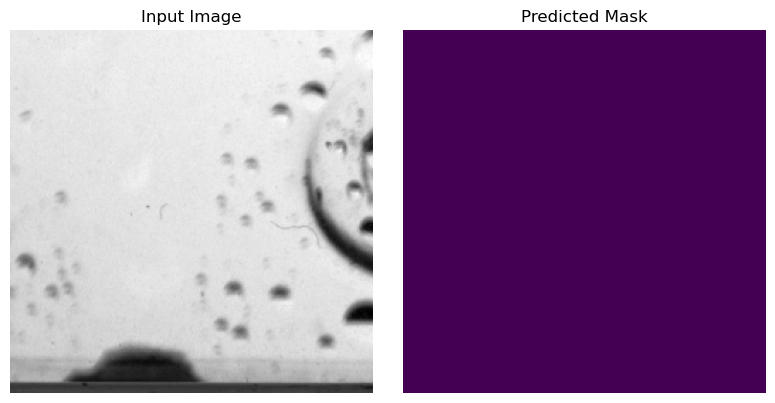

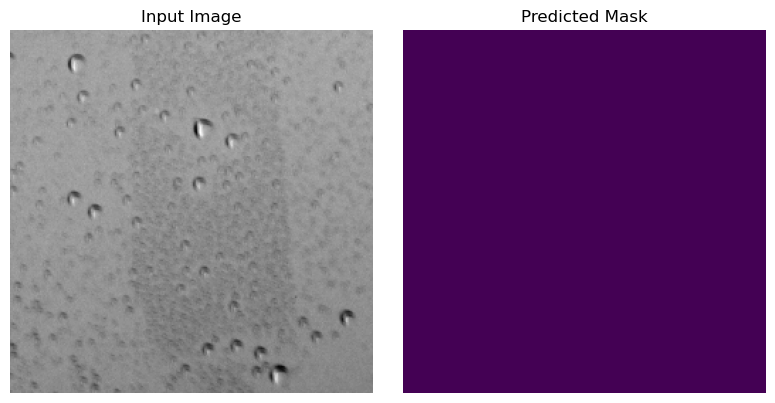

In [105]:
# Save example input images and resulting segmentation masks
for idx in random_indices:
    sample_image = X_test[idx]
    sample_mask_pred = bin_y_pred[idx] > 0.5
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask_pred, cmap='viridis', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [106]:
# Save the model
bin_model.save('bin_model.h5')

**Binary model on seeds**

In [107]:
# Binary model on seed
y_train_seed = y_train[:, :, :, 3:4]  # This slices out the fourth channel
y_test_seed = y_test[:, :, :, 3:4]  # This slices out the fourth channel

In [108]:
seed_model = simple_bin_unet_model(256, 256, 1)

In [109]:
early_stop_seed = EarlyStopping(monitor='val_loss', patience=5, verbose=2, restore_best_weights=True)
history_seed = seed_model.fit(X_train, y_train_seed, validation_data=(X_test, y_test_seed), epochs=10, batch_size=32, callbacks=early_stop_seed)

Epoch 1/10
116/116 [==============================] - 3843s 33s/step - loss: 0.0230 - accuracy: 0.9859 - f1: 5.6133e-05 - iou: 5.4207e-05 - val_loss: 0.0062 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 4.1551e-04
Epoch 2/10
116/116 [==============================] - 623s 5s/step - loss: 0.0013 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 5.3115e-05 - val_loss: 0.0021 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 2.4153e-04
Epoch 3/10
116/116 [==============================] - 657s 6s/step - loss: 0.0012 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 7.4588e-05 - val_loss: 9.3364e-04 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 1.1982e-04
Epoch 4/10
116/116 [==============================] - 655s 6s/step - loss: 0.0011 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 7.3299e-05 - val_loss: 0.0013 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 1.8963e-04
Epoch 5/10
116/116 [==============================] - 652s 6s/step - loss: 0.0012 - accuracy: 0.9999 - f1: 0.0

In [110]:
seed_y_pred = seed_model.predict(X_test)

54/54 [==============================] - 68s 1s/step


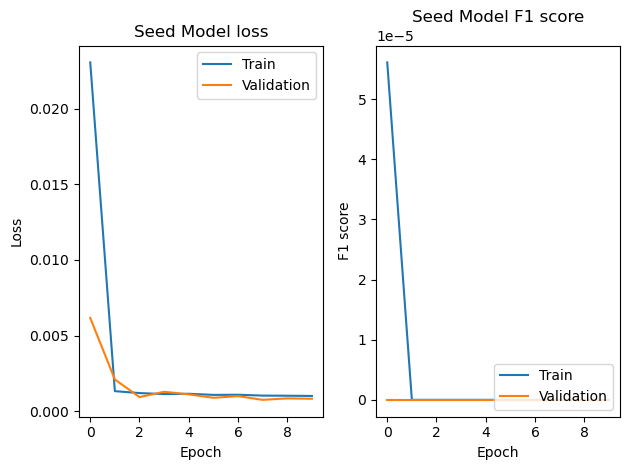

In [111]:
# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_seed.history['loss'])
plt.plot(history_seed.history['val_loss'])
plt.title('Seed Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history_seed.history['f1'])
plt.plot(history_seed.history['val_f1'])
plt.title('Seed Model F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [112]:
# Calculate IoU for seed on the test set
seed_test_iou = iou(y_test_seed, seed_y_pred).numpy().mean()
print(f'IoU for seed on the test set: {seed_test_iou:.4f}')

IoU for seed on the test set: 0.0002


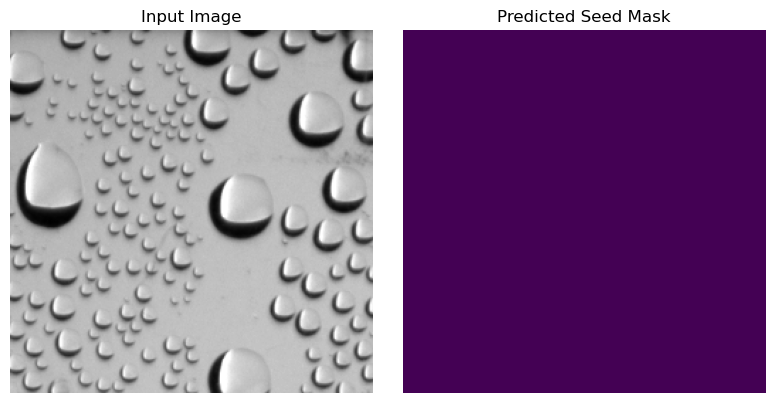

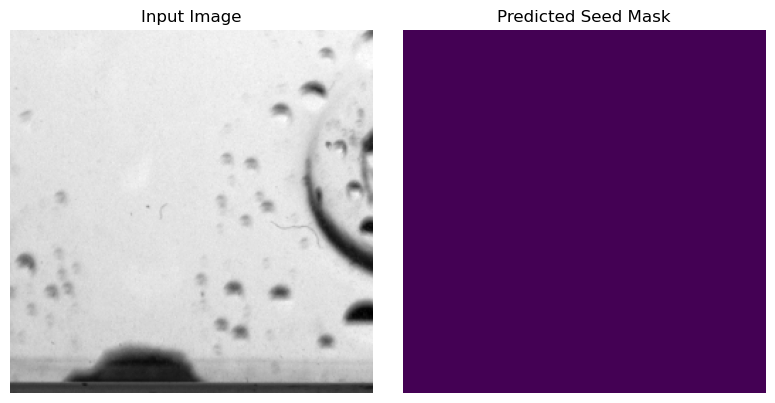

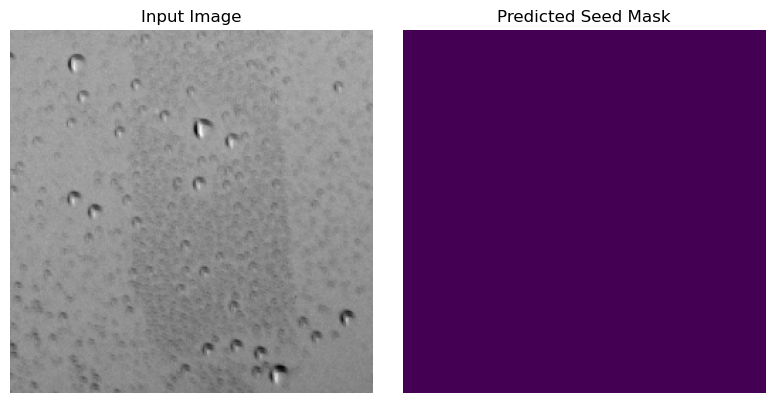

In [113]:
# Save example input images and resulting segmentation masks for seed
for idx in random_indices:
    sample_image = X_test[idx]
    sample_mask_pred = seed_y_pred[idx] > 0.5
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask_pred, cmap='viridis', vmin=0, vmax=1)
    plt.title('Predicted Seed Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [114]:
# Save the model
seed_model.save('seed_model.h5')

**Binary model on shoots**

In [115]:
# Binary model on shoot
y_train_shoot = y_train[:, :, :, 1:2]  # This slices out the second channel
y_test_shoot = y_test[:, :, :, 1:2]  # This slices out the second channel

In [116]:
shoot_model = simple_bin_unet_model(256, 256, 1)

In [117]:
early_stop_shoot = EarlyStopping(monitor='val_loss', patience=5, verbose=2, restore_best_weights=True)
history_shoot = shoot_model.fit(X_train, y_train_shoot, validation_data=(X_test, y_test_shoot), epochs=10, batch_size=32, callbacks=early_stop_shoot)

Epoch 1/10
116/116 [==============================] - 673s 6s/step - loss: 0.0550 - accuracy: 0.9830 - f1: 0.1023 - iou: 0.0294 - val_loss: 0.0202 - val_accuracy: 0.9933 - val_f1: 0.0240 - val_iou: 0.0307
Epoch 2/10
116/116 [==============================] - 655s 6s/step - loss: 0.0140 - accuracy: 0.9944 - f1: 0.5686 - iou: 0.0668 - val_loss: 0.0113 - val_accuracy: 0.9957 - val_f1: 0.2367 - val_iou: 0.0731
Epoch 3/10
116/116 [==============================] - 654s 6s/step - loss: 0.0096 - accuracy: 0.9963 - f1: 0.7319 - iou: 0.0838 - val_loss: 0.0101 - val_accuracy: 0.9961 - val_f1: 0.1866 - val_iou: 0.0632
Epoch 4/10
116/116 [==============================] - 647s 6s/step - loss: 0.0072 - accuracy: 0.9973 - f1: 0.8270 - iou: 0.0925 - val_loss: 0.0079 - val_accuracy: 0.9971 - val_f1: 0.2705 - val_iou: 0.0824
Epoch 5/10
116/116 [==============================] - 653s 6s/step - loss: 0.0065 - accuracy: 0.9976 - f1: 0.8231 - iou: 0.0979 - val_loss: 0.0076 - val_accuracy: 0.9974 - val_f1: 

In [118]:
shoot_y_pred = shoot_model.predict(X_test)

54/54 [==============================] - 81s 2s/step


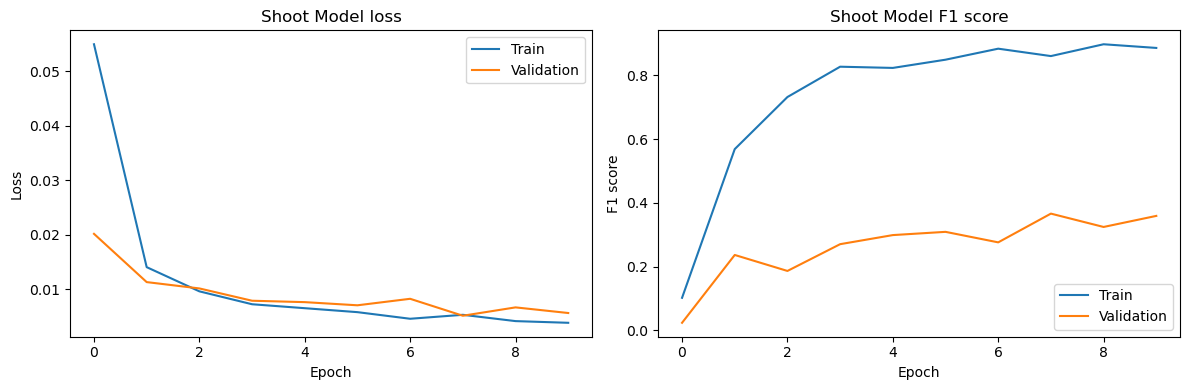

In [119]:
# Plotting learning curves for shoot
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_shoot.history['loss'])
plt.plot(history_shoot.history['val_loss'])
plt.title('Shoot Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history_shoot.history['f1'])
plt.plot(history_shoot.history['val_f1'])
plt.title('Shoot Model F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [120]:
# Calculate IoU for shoot on the test set
shoot_test_iou = iou(y_test_shoot, shoot_y_pred).numpy().mean()
print(f'IoU for shoot on the test set: {shoot_test_iou:.4f}')

IoU for shoot on the test set: 0.1058


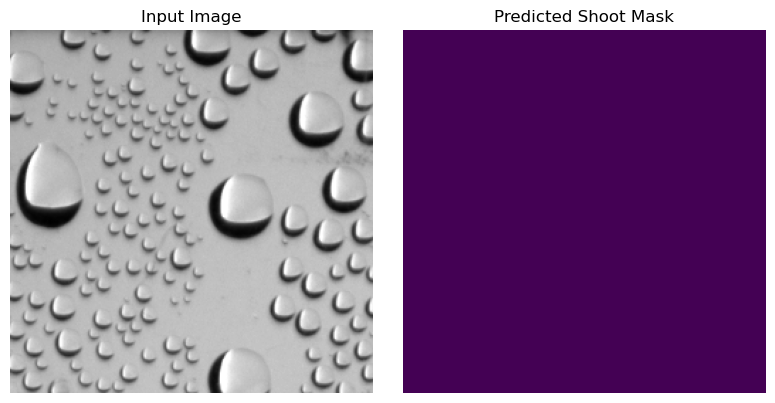

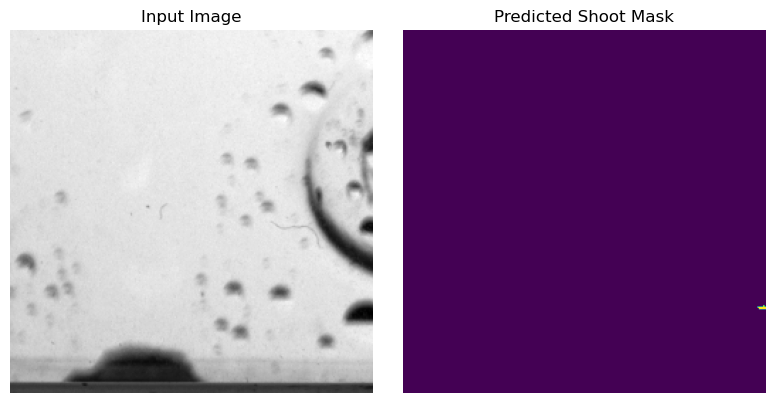

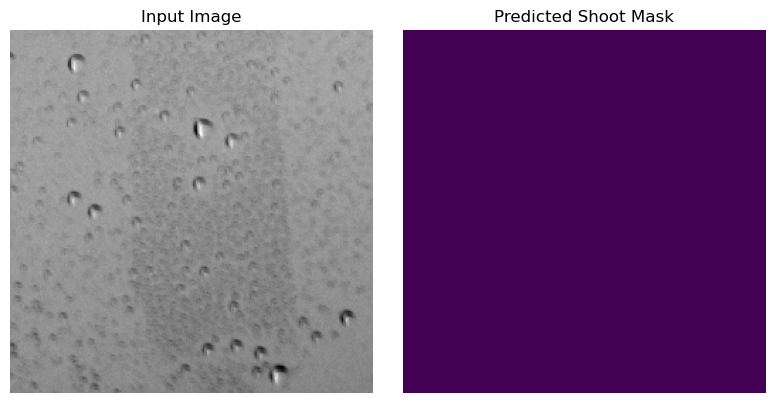

In [121]:
# Save example input images and resulting segmentation masks for shoot
for idx in random_indices:
    sample_image = X_test[idx]
    sample_mask_pred = shoot_y_pred[idx] > 0.5
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask_pred, cmap='viridis', vmin=0, vmax=1)
    plt.title('Predicted Shoot Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [122]:
# Save the model
shoot_model.save('shoot_model.h5')

**Binary model on occuled_root**

In [123]:
# Binary model on occluded_root
y_train_occ_root = y_train[:, :, :, 2:3]  # This slices out the third channel
y_test_occ_root = y_test[:, :, :, 2:3]  # This slices out the third channel

In [124]:
occ_root_model = simple_bin_unet_model(256, 256, 1)

In [125]:
early_stop_occ_root = EarlyStopping(monitor='val_loss', patience=5, verbose=2, restore_best_weights=True)
history_occ_root = occ_root_model.fit(X_train, y_train_occ_root, validation_data=(X_test, y_test_occ_root), epochs=10, batch_size=32, callbacks=early_stop_occ_root)

Epoch 1/10
116/116 [==============================] - 57362s 499s/step - loss: 0.0805 - accuracy: 0.9834 - f1: 7.8147e-04 - iou: 0.0075 - val_loss: 0.0380 - val_accuracy: 0.9929 - val_f1: 0.0000e+00 - val_iou: 0.0076
Epoch 2/10
116/116 [==============================] - 778s 7s/step - loss: 0.0532 - accuracy: 0.9893 - f1: 0.0020 - iou: 0.0103 - val_loss: 0.0364 - val_accuracy: 0.9929 - val_f1: 0.0000e+00 - val_iou: 0.0108
Epoch 3/10
116/116 [==============================] - 777s 7s/step - loss: 0.0429 - accuracy: 0.9898 - f1: 0.1023 - iou: 0.0457 - val_loss: 0.0226 - val_accuracy: 0.9942 - val_f1: 0.3211 - val_iou: 0.0923
Epoch 4/10
116/116 [==============================] - 761s 7s/step - loss: 0.0301 - accuracy: 0.9917 - f1: 0.4851 - iou: 0.1189 - val_loss: 0.0203 - val_accuracy: 0.9945 - val_f1: 0.3467 - val_iou: 0.1013
Epoch 5/10
116/116 [==============================] - 761s 7s/step - loss: 0.0235 - accuracy: 0.9927 - f1: 0.5834 - iou: 0.1472 - val_loss: 0.0153 - val_accuracy: 0

In [126]:
occ_root_y_pred = occ_root_model.predict(X_test)

54/54 [==============================] - 82s 2s/step


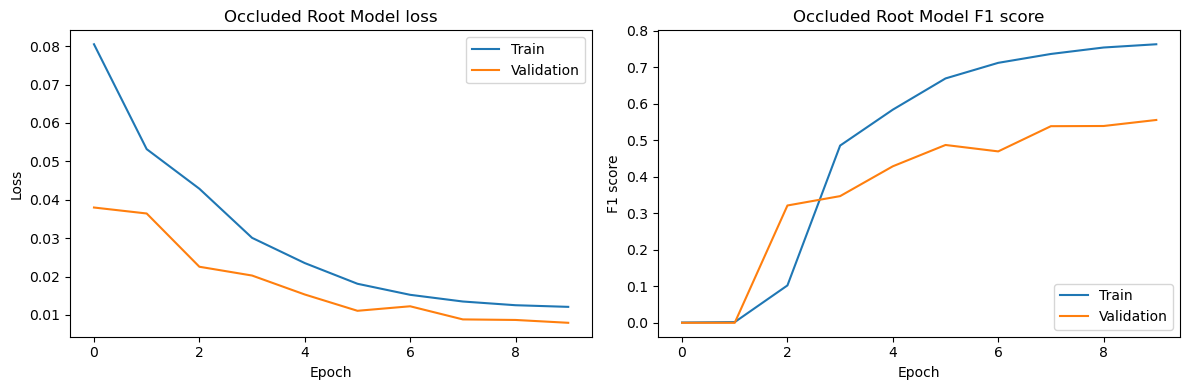

In [127]:
# Plotting learning curves for occluded_root
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_occ_root.history['loss'])
plt.plot(history_occ_root.history['val_loss'])
plt.title('Occluded Root Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history_occ_root.history['f1'])
plt.plot(history_occ_root.history['val_f1'])
plt.title('Occluded Root Model F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [128]:
# Calculate IoU for occluded_root on the test set
occ_root_test_iou = iou(y_test_occ_root, occ_root_y_pred).numpy().mean()
print(f'IoU for occluded_root on the test set: {occ_root_test_iou:.4f}')

IoU for occluded_root on the test set: 0.1994


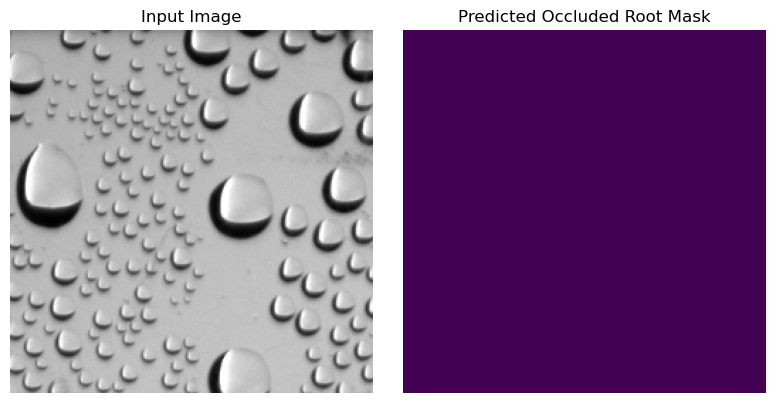

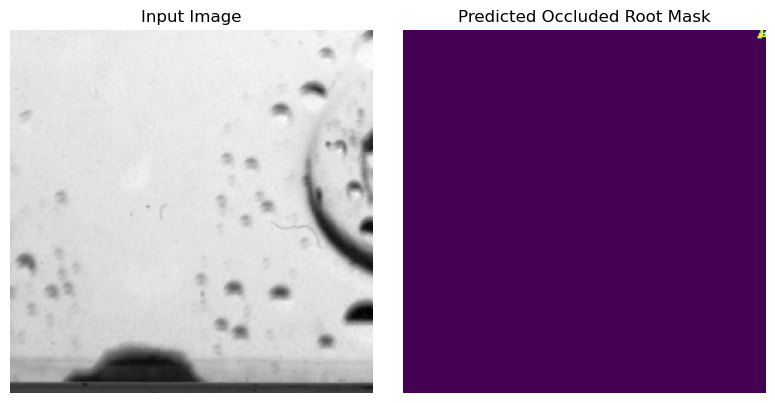

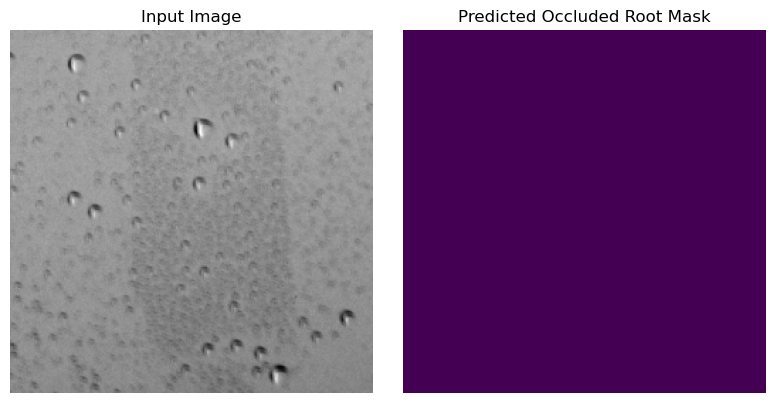

In [129]:
# Save example input images and resulting segmentation masks for occluded_root
for idx in random_indices:
    sample_image = X_test[idx]
    sample_mask_pred = occ_root_y_pred[idx] > 0.5
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask_pred, cmap='viridis', vmin=0, vmax=1)
    plt.title('Predicted Occluded Root Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [130]:
# Save the model
occ_root_model.save('occ_root_model.h5')